# Quantum Cross Correlation

Quantum Cross Correlation is a quantum version of the classical cross-correlation algorithm based on Fourier transformations. In essence, the classical computation of a correlation map $C_\text{map}$ uses the convolution theorem, which enables the use of Fast Fourier Transformations, denoted as $\mathcal{F}\{\cdot \}$. With the component-wise product '$\circ$', the correlation map is classically computed via 

$$C_\text{map} =\mathcal{F}^{-1}\{\mathcal{F}\{A \} \circ \mathcal{F}\{B \}  \}  $$

where $A$ and $B$ are the input signals. The correlation peak is where the map has its maximal entries and refers to the displacement of the input signals. For Particle Image Velocimetry, images of particles in a fluid are evaluated in this way to determine the flow velocity in the interrogation area. This programming project demonstrates this application for self-generated inputs.


## Input Generation

The first task is to generate input pairs which will then be subject to the correlation algorithm. 

Image 1:

* Generate a numpy array with $N^2$ entries where $N=2^n$ is the amount of pixels per edge in the quadratic image and $n=3$ is the amount of qubits.
* Generate N random integers in $0, 1, ..., N^2-1$. Use np.random.choice($N^2$,$N$) and define with np.random.seed(1) a random seed such that results are reproducible.
* Reshape the numpy array to an N$\times$N image with np.reshape( .. , (N,N))

Image 2: 

* For the beginning, we focus on simple periodic shifts by full cells. Use np.roll( ... ,(dx,dy),(x,y)) to shift the first image by one cell in both directions.


In the end, draw the images with matplotlib via plt.imshow( .. )

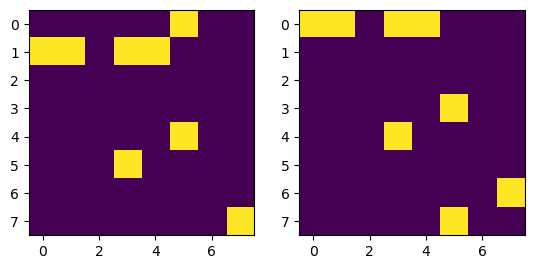

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n=3
N=2**n
A = np.zeros(N**2)

# fill from here

# fill appropriately
plt.subplot(121)
plt.imshow(#... )
plt.subplot(122)
plt.imshow(#... )

## Classical Cross Correlation

Scipy has a correlate funtion which realizes the cross correlation between two data arrays. Use correlate to create the correlation map and draw the map as an image.

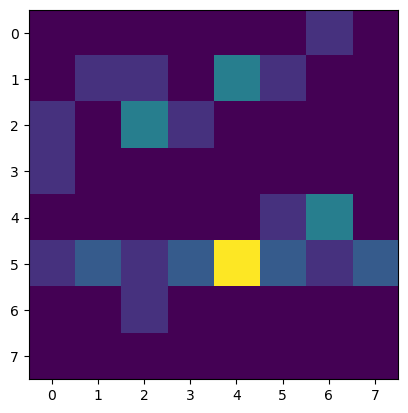

In [2]:
from scipy.signal import correlate
plt.imshow(correlate(#  .., .., mode='same'))

## Quantum Cross-Correlation

Similar to the seminar, we can implement the 2D quantum cross correlation, where the key difference is that we need 2 smaller QFTs per image.
* Copy the code of the seminar and adapt it where necessary.
* Reshape the images back to one large vector, using np.reshape( ... , $N^2$). Initialize those two vectors on seperate qubit registers
* Place two equally sized QFTs in the positions where there was only one QFT before. For instance, the first image as a vector will span over 2n qubits. Place one QFT on list(range(n)) and the second on list(range(n,2*n)). Continue this for all other QFTs in the original algorithm.

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Import QFT Circuit here

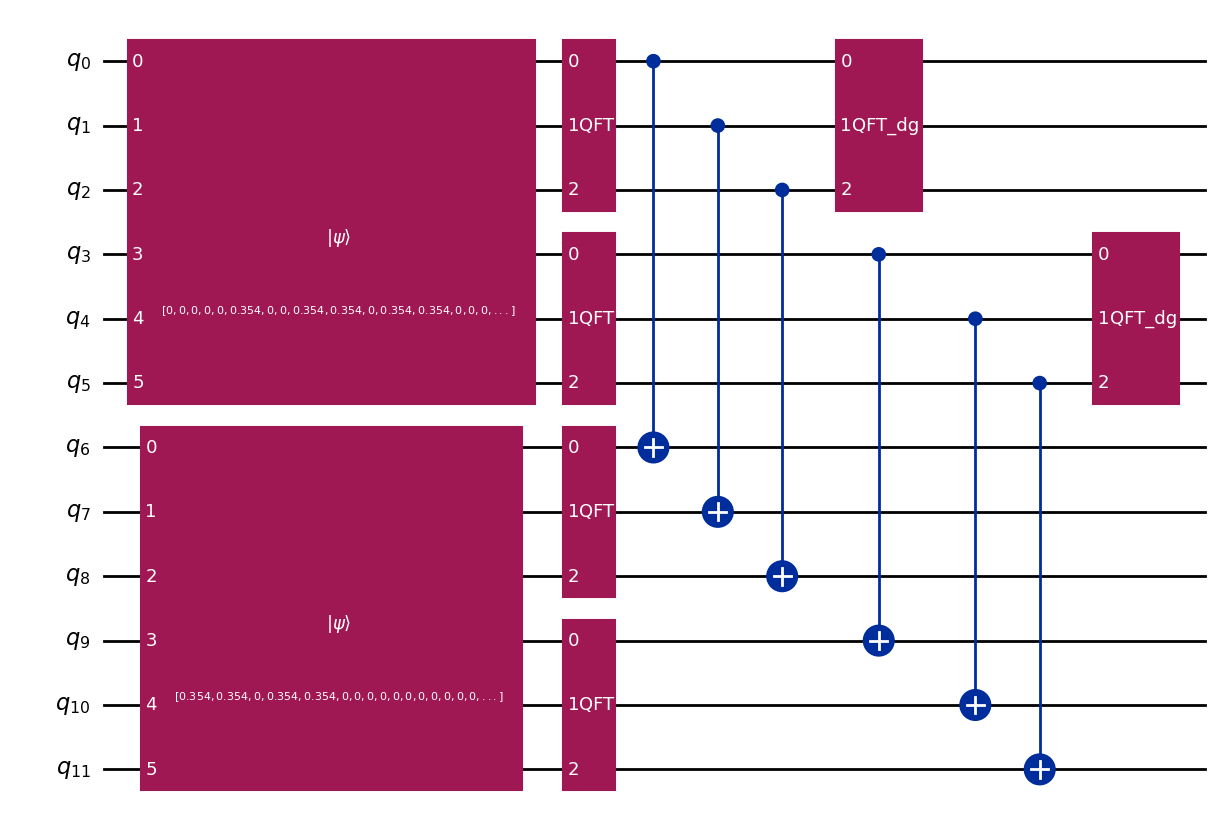

In [4]:
qc = QuantumCircuit(4*n)
# fill from here

# fill till here
qc.draw('mpl') # if 'mpl' does not work on your device, remove it from ithe instruction

Evaluate the quantum state and plot the resulting correlation map as an image. Remember that the result here is slightly different and half as large in each dimension as the classical calculation does the linear correlation, while for this project we will only do the circular correlation. Assure that the correlation peak is on the same position.

* Use the np.fft.fftshift function to sort the results properly.
* Reshape the result as before with np.reshape(.., ..)
* Use np.real(..) such that matplotlib can illustrate the image. Though the result is purely real, the quantum state will be defined with complex numbers, which causes problems for the plt.imshow(..) command.

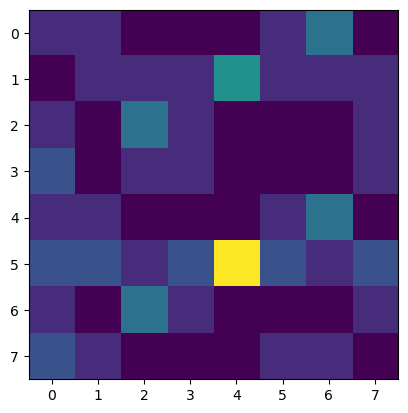

In [5]:
# Run statevector simulation and plot the result as an image


## Sampling

Implement the circuit above with measurements on all qubits and find out with how many shots are needed to identify the correlation peak correctly.

* For the identification of the amount of shots, it is recommended to plot the correlation map and check in which cases the correlation peak is at the correct position. Try to reduce the amount of shots as strong as possible and assure that in ~4/5 of all executions, the peak is on the right position.
* Copy the fundamental sampling code from the moodle page
* Use a copy of the last circuit and use measure_all() to avoid placing unintended measurements
* The following function helps to generate a np.array from the dictionary that .get_counts() produces

In [6]:
def get_vec_from_counts(Counts, Qubits):
    v = np.zeros(2**Qubits)
    for k in range(0,2**Qubits):
            key = format(k, '0' + str(Qubits)+'b')
            if key in Counts1:
                v[k] = Counts1[key]
                
    return v

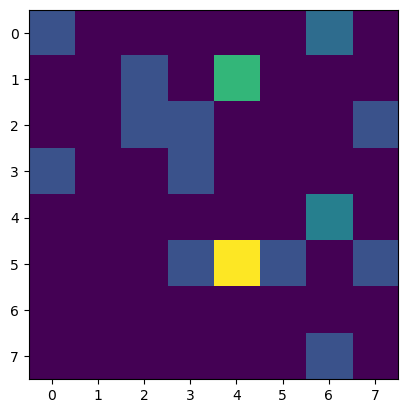

In [7]:
qc_ = qc.copy()
qc_.measure_all()

from qiskit.primitives import StatevectorSampler

# fill here, import sampling routine

# plot results
plt.imshow(#... )

## Amplitude Amplification

The key problem of the algorithm is that only the measurements matter where the lower qubits are in the $\vert 0 \rangle$ state. With amplitude amplification, one can choose amplitudes of the quantum state to become bigger, which in return makes amplitudes smaller that are not elevant for the output information. Amplitude Amplification works by projection operators $P_0,P_G$ and the base circuit $U$. For $r$ amplifications, the circuit takes the form

$$ \left( U P_0 U^\dagger P_G \right)^r \ \ U \vert 00..0\rangle.$$

By this project, you have already implemented $U \vert 00..0\rangle$. 

$P_0$ is the operator which marks the global $\vert00..0\rangle$ state. As a circuit, this works by a multi-controlled Z gate with X gates around it. An exemplaric function to create such a circuit can be found below.

In [8]:
def qc0(n):
    qc_0 = QuantumCircuit(n,name='D0')
    qc_0.x(list(range(n))); qc_0.mcp(np.pi,list(range(n-1)),n-1) ;qc_0.x(list(range(n)))
    return qc_0

qc0(5).draw()

┌───┐       ┌───┐
q_0: ┤ X ├─■─────┤ X ├
     ├───┤ │     ├───┤
q_1: ┤ X ├─■─────┤ X ├
     ├───┤ │     ├───┤
q_2: ┤ X ├─■─────┤ X ├
     ├───┤ │     ├───┤
q_3: ┤ X ├─■─────┤ X ├
     ├───┤ │P(π) ├───┤
q_4: ┤ X ├─■─────┤ X ├
     └───┘       └───┘

$P_G$ is an operator that marks the elements we wish to measure more often (the 'good' elements). In the herein case, these elements are those where the lower qubits are in the $\vert00...0\rangle$ state.

Use the circuits and functions above to create a function which returns the circuit after $r$ amplification steps. $r$ is a tunable integer.

* The code below already gives a blueprint and solves the problem that the state preparation adds reset gates which can not be properly inverted. 
* Also, it already creates a new circuit inside which will be the output. Use mainly .append() for missing blocks 
* The circuit from the previous section (wthout measurements) is $U$. You can create $U^\dagger$ with .inverse()
* $P_0$ should span over all qubits as it marks the global ground state
* $P_G$ marks the ground state on the lower qubits.
* The expression $\left( U P_0 U^\dagger P_G \right)^r$ means to add $P_G$ first, then $U^\dagger$, then $P_0$ and then $U$. This should be repeated $r$ times

In [9]:
from qiskit import transpile

def amplified_circuit(U, n_, r):
   #Precondition U for amplification 
    U_ = transpile(U,basis_gates=['u3','cx','cp','h','x','mcx']).copy(name='U')
    for k in range(len(U_.data)-n_):
        if U_.data[k].operation.name == 'reset':
            U_.data.pop(k)
    
    qc_ = QuantumCircuit(n_)
    
    # Fill here
        
    return qc_

qc_A = amplified_circuit(qc,4*n,2)
print('An example for r=2:')
qc_A.draw()

An example for r=2:


┌─────┐       ┌────────┐┌──────┐┌─────┐       ┌────────┐┌──────┐┌─────┐
 q_0: ┤0    ├───────┤0       ├┤0     ├┤0    ├───────┤0       ├┤0     ├┤0    ├
      │     │       │        ││      ││     │       │        ││      ││     │
 q_1: ┤1    ├───────┤1       ├┤1     ├┤1    ├───────┤1       ├┤1     ├┤1    ├
      │     │       │        ││      ││     │       │        ││      ││     │
 q_2: ┤2    ├───────┤2       ├┤2     ├┤2    ├───────┤2       ├┤2     ├┤2    ├
      │     │       │        ││      ││     │       │        ││      ││     │
 q_3: ┤3    ├───────┤3       ├┤3     ├┤3    ├───────┤3       ├┤3     ├┤3    ├
      │     │       │        ││      ││     │       │        ││      ││     │
 q_4: ┤4    ├───────┤4       ├┤4     ├┤4    ├───────┤4       ├┤4     ├┤4    ├
      │     │       │        ││      ││     │       │        ││      ││     │
 q_5: ┤5    ├───────┤5       ├┤5     ├┤5    ├───────┤5       ├┤5     ├┤5    ├
      │   U │┌─────┐│   U_dg ││   D0 ││   U │┌─────┐│   U_dg ││   D0 ││   U │
 q_6: ┤6    ├┤0    ├┤6       ├┤6     ├┤6    ├┤0    ├┤6       ├┤6     ├┤6    ├
      │     ││     ││        ││      ││     ││     ││        ││      ││     │
 q_7: ┤7    ├┤1    ├┤7       ├┤7     ├┤7    ├┤1    ├┤7       ├┤7     ├┤7    ├
      │     ││     ││        ││      ││     ││     ││        ││      ││     │
 q_8: ┤8    ├┤2    ├┤8       ├┤8     ├┤8    ├┤2    ├┤8       ├┤8     ├┤8    ├
      │     ││  D0 ││        ││      ││     ││  D0 ││        ││      ││     │
 q_9: ┤9    ├┤3    ├┤9       ├┤9     ├┤9    ├┤3    ├┤9       ├┤9     ├┤9    ├
      │     ││     ││        ││      ││     ││     ││        ││      ││     │
q_10: ┤10   ├┤4    ├┤10      ├┤10    ├┤10   ├┤4    ├┤10      ├┤10    ├┤10   ├
      │     ││     ││        ││      ││     ││     ││        ││      ││     │
q_11: ┤11   ├┤5    ├┤11      ├┤11    ├┤11   ├┤5    ├┤11      ├┤11    ├┤11   ├
      └─────┘└─────┘└────────┘└──────┘└─────┘└─────┘└────────┘└──────┘└─────┘

Plot the resulting correlation map for $r=0,1,2$ with statevector simulations. Observe the evolution of the norm of that image, which indicates how probable it is to measure it.

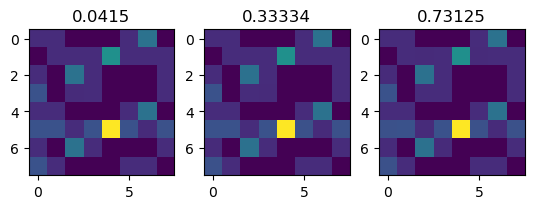

In [10]:
for r in range(3):
    qc_A = amplified_circuit(qc,4*n,r)
    # Generate the image as before it and name it "Ima"

    # End Fill
    plt.subplot(131+r)
    plt.imshow((-1)**r * np.real(Ima))
    plt.title(np.round(np.linalg.norm(Ima)**2,5))

Repeat the evaluation from above but with shot based simulations. Replace the norm in the title with the sum of measurements in the plotted image.

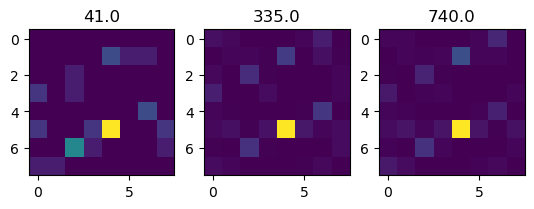

In [11]:
# Fill here

This point marks the end for the 1 person project. Everything that follows is only necessary for groups with $\geq 2$ participants.

## Sum of Correlation

A problem often encountered in practical applications is that a single cross-correlation is not reliabe enough to identify the correlation peak, for instance due to noise. In those cases, one can use sum of correlation which means that one sums together multiple correlation maps where it is assumed that the displacement / correlation peak is fundamentally equal in all used images. Mathematically, we evaluate
$$ C_\text{map,final} = \sum_{j=1}^J C_\text{map,j}.$$

1. Create 4 different image pairs with the same displacement. Use different random seeds and displace them as before.
2. Add two additional qubits to the circuit. Place a Hadamard gate on each.
3. Load the images conditioned on the lower qubits. For example, prepare the first image pair if the lower qubits are in the $\vert 00 \rangle$ state and the last if they are in the $\vert 11 \rangle$ state.
4. Place Hadamar gates on the last two qubits again. This will realize the sum of the correlation map if those qubits are in the $\vert 00 \rangle$ state after the Hadamard gates.

Further help for 3. is given below:
* Transpile the state preparation as given in the amplitude amplification section. This is mainly necessary because the resets will cause problems otherwise.
* Make this transpiled circuit a controlled gate. You can find commands for this in the Quantum Phase Estimation Seminar or online.
* The easiest way to go from one image pair to the next is to add $X$ gates on the lower qubits and keep the $\vert 1\rangle$-controlled gate-type. For instance, if you iterate over 4 images, it is useful to work with 'j modulo 2' for the X-Gate position. In that case, the $\vert 1 \rangle$ controlled type will implement on the original $\vert 11\rangle$ case. After one X Gate the original $\vert 10\rangle $ state will be the next, followed by original $\vert 00\rangle $ and then $\vert 01\rangle$.

Draw the circuit for 4 image pairs.

In [12]:
qc_base = QuantumCircuit(4*n+2)

# Fill code

qc_base.draw()

┌────┐           ┌────┐           ┌────┐           ┌────┐┌──────┐»
 q_0: ─────┤0   ├───────────┤0   ├───────────┤0   ├───────────┤0   ├┤0     ├»
           │    │           │    │           │    │           │    ││      │»
 q_1: ─────┤1   ├───────────┤1   ├───────────┤1   ├───────────┤1   ├┤1 QFT ├»
           │    │           │    │           │    │           │    ││      │»
 q_2: ─────┤2   ├───────────┤2   ├───────────┤2   ├───────────┤2   ├┤2     ├»
           │  U │           │  U │           │  U │           │  U │├──────┤»
 q_3: ─────┤3   ├───────────┤3   ├───────────┤3   ├───────────┤3   ├┤0     ├»
           │    │           │    │           │    │           │    ││      │»
 q_4: ─────┤4   ├───────────┤4   ├───────────┤4   ├───────────┤4   ├┤1 QFT ├»
           │    │           │    │           │    │           │    ││      │»
 q_5: ─────┤5   ├───────────┤5   ├───────────┤5   ├───────────┤5   ├┤2     ├»
           └─┬──┘┌────┐     └─┬──┘┌────┐     └─┬──┘┌────┐     └─┬──┘└┬────┬┘»
 q_6: ───────┼───┤0   ├───────┼───┤0   ├───────┼───┤0   ├───────┼────┤0   ├─»
             │   │    │       │   │    │       │   │    │       │    │    │ »
 q_7: ───────┼───┤1   ├───────┼───┤1   ├───────┼───┤1   ├───────┼────┤1   ├─»
             │   │    │       │   │    │       │   │    │       │    │    │ »
 q_8: ───────┼───┤2   ├───────┼───┤2   ├───────┼───┤2   ├───────┼────┤2   ├─»
             │   │  U │       │   │  U │       │   │  U │       │    │  U │ »
 q_9: ───────┼───┤3   ├───────┼───┤3   ├───────┼───┤3   ├───────┼────┤3   ├─»
             │   │    │       │   │    │       │   │    │       │    │    │ »
q_10: ───────┼───┤4   ├───────┼───┤4   ├───────┼───┤4   ├───────┼────┤4   ├─»
             │   │    │       │   │    │       │   │    │       │    │    │ »
q_11: ───────┼───┤5   ├───────┼───┤5   ├───────┼───┤5   ├───────┼────┤5   ├─»
      ┌───┐  │   └─┬──┘┌───┐  │   └─┬──┘       │   └─┬──┘┌───┐  │    └─┬──┘ »
q_12: ┤ H ├──■─────■───┤ X ├──■─────■──────────■─────■───┤ X ├──■──────■────»
      ├───┤  │     │   └───┘  │     │   ┌───┐  │     │   └───┘  │      │    »
q_13: ┤ H ├──■─────■──────────■─────■───┤ X ├──■─────■──────────■──────■────»
      └───┘                             └───┘                               »
«                             ┌─────────┐                     
« q_0: ──────────■────────────┤0        ├─────────────────────
«                │            │         │                     
« q_1: ──────────┼────■───────┤1 QFT_dg ├─────────────────────
«                │    │       │         │                     
« q_2: ──────────┼────┼────■──┤2        ├─────────────────────
«                │    │    │  └─────────┘          ┌─────────┐
« q_3: ──────────┼────┼────┼───────■───────────────┤0        ├
«                │    │    │       │               │         │
« q_4: ──────────┼────┼────┼───────┼───────■───────┤1 QFT_dg ├
«                │    │    │       │       │       │         │
« q_5: ──────────┼────┼────┼───────┼───────┼────■──┤2        ├
«      ┌──────┐┌─┴─┐  │    │       │       │    │  └─────────┘
« q_6: ┤0     ├┤ X ├──┼────┼───────┼───────┼────┼─────────────
«      │      │└───┘┌─┴─┐  │       │       │    │             
« q_7: ┤1 QFT ├─────┤ X ├──┼───────┼───────┼────┼─────────────
«      │      │     └───┘┌─┴─┐     │       │    │             
« q_8: ┤2     ├──────────┤ X ├─────┼───────┼────┼─────────────
«      ├──────┤          └───┘   ┌─┴─┐     │    │             
« q_9: ┤0     ├──────────────────┤ X ├─────┼────┼─────────────
«      │      │                  └───┘   ┌─┴─┐  │             
«q_10: ┤1 QFT ├──────────────────────────┤ X ├──┼─────────────
«      │      │                          └───┘┌─┴─┐           
«q_11: ┤2     ├───────────────────────────────┤ X ├───────────
«      └┬───┬─┘                               └───┘           
«q_12: ─┤ H ├─────────────────────────────────────────────────
«       ├───┤  ┌───┐                                          
«q_13: ─┤ X ├──┤ H ├────────────────────────────

Evaluate this circuit with a statevector simulation and verify whether you can identify the correlation peak at the position where it is expected.

Text(0.5, 1.0, '0.17457')

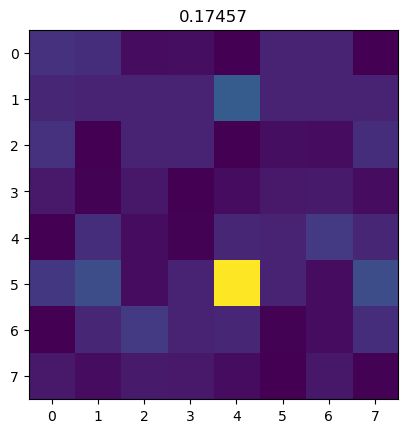

In [13]:
# Fill here

Adapt and/or use the amplitude amplification routine from above to identify the optimal amount of amplifications. In this project, this means that we want the maximal norm of the correlation map while the amount of amplifications is minimal.

* It should be checked, that the projectors span appropriately. As we have two additional qubits, $P_0$ still spans over all qubits while $P_G$ should also account for the $\vert 00 \rangle$ state on the two additional qubits.
* A short research about amplitude amplification may gives you a good estimate about the amount of amplifications. The simulations here can take some minutes because the circuits are both large by multiple images and deep by multiple amplifications

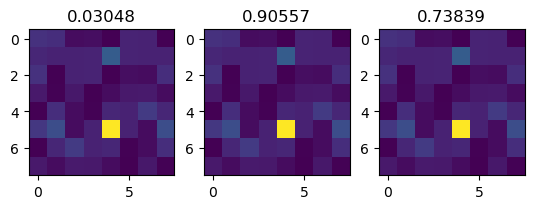

In [14]:
# fill here

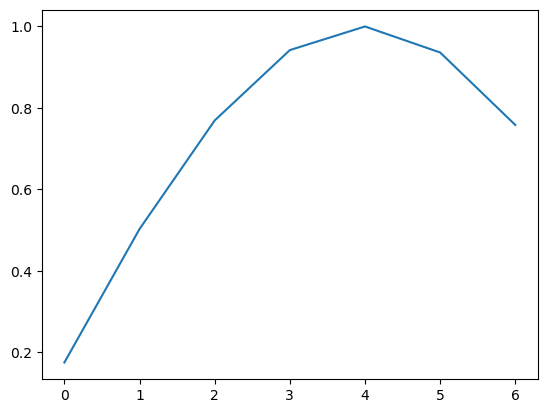

In [15]:
# The following curve illustrates a characteristic feature of amplitude amplification